<a href="https://colab.research.google.com/github/LatiefDataVisionary/demand-forecasting-retail-college-task/blob/main/notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Demand Forecasting for Retail: A Machine Learning Pipeline Approach**

## **Project Overview**

**College Course:** Model Development Engineering

**Objective:** To develop a robust machine learning model to accurately forecast daily product demand for a retail company. This involves a comprehensive data pipeline, including merging multiple data sources, extensive feature engineering, and model comparison to optimize inventory management and reduce costs.

## **Chapter 1: Project Setup**

This chapter covers the initial setup, including importing necessary libraries and loading the datasets from their sources.

### **1.1. Import Libraries**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# Set plotting style
sns.set_style("whitegrid")

### **1.2. Load Datasets**

In [64]:
data1 = 'https://raw.githubusercontent.com/LatiefDataVisionary/demand-forecasting-retail-college-task/refs/heads/main/data/raw/Dataset%201_Retail%20Store%20Inventory%20and%20Demand%20Forecasting.csv'
data2 = 'https://raw.githubusercontent.com/LatiefDataVisionary/demand-forecasting-retail-college-task/refs/heads/main/data/raw/Dataset%202_Retail%20Sales%20Data%20with%20Seasonal%20Trends%20%26%20Marketing.csv'
data3 = 'https://raw.githubusercontent.com/LatiefDataVisionary/demand-forecasting-retail-college-task/refs/heads/main/data/raw/Dataset%203_Strategic%20Supply%20Chain%20Demand%20Forecasting%20Dataset.csv'

df1 = pd.read_csv(data1)
df2 = pd.read_csv(data2)
df3 = pd.read_csv(data3)

print("df1 loaded successfully.")
print("df2 loaded successfully.")
print("df3 loaded successfully.")

df1 loaded successfully.
df2 loaded successfully.
df3 loaded successfully.


#### **1.2.1. Data Information**

In [65]:
df1.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [66]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null  int64  
dtypes: f

In [67]:
df2.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0


In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              30000 non-null  int64  
 1   MONTH             30000 non-null  int64  
 2   SUPPLIER          29967 non-null  object 
 3   ITEM CODE         30000 non-null  object 
 4   ITEM DESCRIPTION  30000 non-null  object 
 5   ITEM TYPE         30000 non-null  object 
 6   RETAIL SALES      29999 non-null  float64
 7   RETAIL TRANSFERS  30000 non-null  float64
 8   WAREHOUSE SALES   30000 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.1+ MB


In [69]:
df3.head()

,date,product_id,sales_units,holiday_season,promotion_applied,competitor_price_index,economic_index,weather_impact,price,discount_percentage,sales_revenue,region_Europe,region_North America,store_type_Retail,store_type_Wholesale,category_Cabinets,category_Chairs,category_Sofas,category_Tables,future_demand
0,2023-01-01,151,99,0,0,0.983893,1.314333,0,126.932922,0.000000,12566.359326,False,False,True,False,False,True,False,False,95.0
1,2023-01-02,192,95,1,0,0.977615,1.439582,0,151.355405,0.000000,14378.763512,False,True,False,False,True,False,False,False,101.0
2,2023-01-03,114,101,0,0,0.983913,1.094795,0,191.701693,0.000000,19361.870952,False,False,False,True,True,False,False,False,33.0
3,2023-01-04,171,33,0,0,1.191956,0.907672,0,173.106487,0.000000,5712.514059,False,False,False,True,False,True,False,False,82.0
4,2023-01-05,160,82,0,1,0.855711,1.479690,0,138.587491,10.995213,10114.659145,True,False,False,False,False,False,True,False,13.0


In [70]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    4999 non-null   object 
 1   product_id              4999 non-null   int64  
 2   sales_units             4999 non-null   int64  
 3   holiday_season          4999 non-null   int64  
 4   promotion_applied       4999 non-null   int64  
 5   competitor_price_index  4999 non-null   float64
 6   economic_index          4999 non-null   float64
 7   weather_impact          4999 non-null   int64  
 8   price                   4999 non-null   float64
 9   discount_percentage     4999 non-null   float64
 10  sales_revenue           4999 non-null   float64
 11  region_Europe           4999 non-null   bool   
 12  region_North America    4999 non-null   bool   
 13  store_type_Retail       4999 non-null   bool   
 14  store_type_Wholesale    4999 non-null   

#### **1.2.2. Data Summary Statistics**

In [71]:
df1.describe(include='all')

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
count,76000,76000,76000,76000,76000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000,76000.000000,76000.000000,76000,76000.000000,76000.000000
unique,760,5,20,5,4,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,4,NaN,NaN
top,2024-01-30,S001,P0001,Groceries,North,NaN,NaN,NaN,NaN,NaN,Cloudy,NaN,NaN,Winter,NaN,NaN
freq,100,15200,3800,30400,30400,NaN,NaN,NaN,NaN,NaN,24360,NaN,NaN,21000,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,301.062842,88.827316,89.090645,67.726028,9.087039,NaN,0.328947,69.454029,NaN,0.200000,104.317158
std,NaN,NaN,NaN,NaN,NaN,226.510161,43.994525,162.404627,39.377899,7.475781,NaN,0.469834,40.943818,NaN,0.400003,46.964801
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.740000,0.000000,NaN,0.000000,4.290000,NaN,0.000000,4.000000
25%,NaN,NaN,NaN,NaN,NaN,136.000000,58.000000,0.000000,31.997500,5.000000,NaN,0.000000,32.620000,NaN,0.000000,71.000000
50%,NaN,NaN,NaN,NaN,NaN,227.000000,84.000000,0.000000,64.500000,10.000000,NaN,0.000000,65.700000,NaN,0.000000,100.000000
75%,NaN,NaN,NaN,NaN,NaN,408.000000,114.000000,121.000000,95.830000,10.000000,NaN,1.000000,97.932500,NaN,0.000000,133.000000


In [72]:
df2.describe(include='all')

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,30000.0,30000.000000,29967,30000,30000,30000,29999.000000,30000.000000,30000.000000
unique,NaN,NaN,290,15668,15732,8,NaN,NaN,NaN
top,NaN,NaN,"THE COUNTRY VINTNER, LLC DBA WINEBOW",16225,TENTH WARD DIST CO CARAWAY RYE - 750ML,WINE,NaN,NaN,NaN
freq,NaN,NaN,2041,4,5,18680,NaN,NaN,NaN
mean,2020.0,3.911467,NaN,NaN,NaN,NaN,6.939796,6.594058,27.431031
std,0.0,2.836788,NaN,NaN,NaN,NaN,33.081054,27.879428,272.166085
min,2020.0,1.000000,NaN,NaN,NaN,NaN,-0.420000,-6.000000,-3999.000000
25%,2020.0,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,2020.0,3.000000,NaN,NaN,NaN,NaN,0.160000,0.000000,1.000000
75%,2020.0,7.000000,NaN,NaN,NaN,NaN,2.920000,3.000000,6.000000


In [73]:
df3.describe(include='all')

,date,product_id,sales_units,holiday_season,promotion_applied,competitor_price_index,economic_index,weather_impact,price,discount_percentage,sales_revenue,region_Europe,region_North America,store_type_Retail,store_type_Wholesale,category_Cabinets,category_Chairs,category_Sofas,category_Tables,future_demand
count,4999,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999,4999,4999,4999,4999,4999,4999,4999,4999.000000
unique,4999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2,NaN
top,2036-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3321,3315,3332,3308,3997,4011,4031,3936,NaN
mean,NaN,148.897780,103.287057,0.201240,0.291458,1.000817,1.006562,0.143429,110.942274,5.131256,10868.506476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.293059
std,NaN,28.966902,54.805135,0.400967,0.454480,0.116095,0.287037,0.350545,51.947268,8.879610,8261.926164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.806308
min,NaN,100.000000,10.000000,0.000000,0.000000,0.800081,0.500021,0.000000,20.016788,0.000000,205.710553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,124.000000,56.000000,0.000000,0.000000,0.900912,0.764042,0.000000,66.092894,0.000000,4246.400673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.000000
50%,NaN,148.000000,101.000000,0.000000,0.000000,0.999048,1.010684,0.000000,111.391956,0.000000,8746.124067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.000000
75%,NaN,174.000000,151.000000,0.000000,1.000000,1.102838,1.253165,0.000000,156.397044,8.850384,15700.271472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.000000


#### **1.2.3. Unique Values and Counts for Object Columns**

In [74]:
for col in df1.select_dtypes(include='object').columns:
    print(f"### Column: {col}\n")
    print(f"**Unique Values:**\n{df1[col].unique()}\n")
    print(f"**Value Counts:**\n{df1[col].value_counts().to_markdown(numalign='left', stralign='left')}\n---")

### Column: Date

**Unique Values:**
['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13' '2022-01-14' '2022-01-15'
 '2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '2022-01-20'
 '2022-01-21' '2022-01-22' '2022-01-23' '2022-01-24' '2022-01-25'
 '2022-01-26' '2022-01-27' '2022-01-28' '2022-01-29' '2022-01-30'
 '2022-01-31' '2022-02-01' '2022-02-02' '2022-02-03' '2022-02-04'
 '2022-02-05' '2022-02-06' '2022-02-07' '2022-02-08' '2022-02-09'
 '2022-02-10' '2022-02-11' '2022-02-12' '2022-02-13' '2022-02-14'
 '2022-02-15' '2022-02-16' '2022-02-17' '2022-02-18' '2022-02-19'
 '2022-02-20' '2022-02-21' '2022-02-22' '2022-02-23' '2022-02-24'
 '2022-02-25' '2022-02-26' '2022-02-27' '2022-02-28' '2022-03-01'
 '2022-03-02' '2022-03-03' '2022-03-04' '2022-03-05' '2022-03-06'
 '2022-03-07' '2022-03-08' '2022-03-09' '2022-03-10' '2022-03-11'
 '2022-03-12' '2022-03-13' '2022-03-14'

In [75]:
for col in df2.select_dtypes(include='object').columns:
    print(f"### Column: {col}\n")
    print(f"**Unique Values:**\n{df2[col].unique()}\n")
    print(f"**Value Counts:**\n{df2[col].value_counts().to_markdown(numalign='left', stralign='left')}\n---")

Streaming output truncated to the last 5000 lines.
| FLYING DOG SNAKE DOG IPA 1/6 KEG                                                  | 1       |
| NB RED ROBIN 1969 LAGER 1/2 KEG                                                   | 1       |
| HEAVY SEAS DRINK LIKE A PIRATE SAMPLER 2/12PK CAN 12OZ                            | 1       |
| BUD LIGHT ORANGE 15PK 25OZ CAN                                                    | 1       |
| Q DRINKS INDIAN TONIC NA - 6.7OZ                                                  | 1       |
| DUCK RABBIT PORTER 4/6 NR                                                         | 1       |
| EPIC TART'N JUICY 4/6 12OZ CANS                                                   | 1       |
| CHAMPION SHOWER BEER 4/6 12OZ CANS                                                | 1       |
| SLY FOX HELLES 4/6 12OZ CANS                                                      | 1       |
| ITHACA FLOWER POWER 4/6 CANS                                                      |

In [76]:
for col in df3.select_dtypes(include='object').columns:
    print(f"### Column: {col}\n")
    print(f"**Unique Values:**\n{df3[col].unique()}\n")
    print(f"**Value Counts:**\n{df3[col].value_counts().to_markdown(numalign='left', stralign='left')}\n---")

Streaming output truncated to the last 5000 lines.
| 2036-09-07 | 1       |
| 2023-01-01 | 1       |
| 2023-01-02 | 1       |
| 2023-01-03 | 1       |
| 2023-01-04 | 1       |
| 2023-01-05 | 1       |
| 2023-01-06 | 1       |
| 2036-08-22 | 1       |
| 2036-08-21 | 1       |
| 2036-08-20 | 1       |
| 2036-08-19 | 1       |
| 2036-08-18 | 1       |
| 2036-08-17 | 1       |
| 2036-08-16 | 1       |
| 2036-08-15 | 1       |
| 2036-08-14 | 1       |
| 2036-08-13 | 1       |
| 2036-08-12 | 1       |
| 2036-08-11 | 1       |
| 2036-08-10 | 1       |
| 2036-08-09 | 1       |
| 2036-08-08 | 1       |
| 2036-08-07 | 1       |
| 2023-02-08 | 1       |
| 2023-02-07 | 1       |
| 2023-02-06 | 1       |
| 2023-02-05 | 1       |
| 2023-02-04 | 1       |
| 2023-02-03 | 1       |
| 2023-02-02 | 1       |
| 2023-02-01 | 1       |
| 2023-01-31 | 1       |
| 2023-01-30 | 1       |
| 2023-01-29 | 1       |
| 2023-01-28 | 1       |
| 2023-01-27 | 1       |
| 2023-01-26 | 1       |
| 2023-01-25 | 1       |

#### **1.2.4. Missing Values Analysis**

In [77]:
print("Missing values in df:")
print(df1.isnull().sum().to_markdown(numalign="left", stralign="left"))

print("\nDuplicate rows in df1:")
print(df1.duplicated().sum())

Missing values in df:
|                    | 0   |
|:-------------------|:----|
| Date               | 0   |
| Store ID           | 0   |
| Product ID         | 0   |
| Category           | 0   |
| Region             | 0   |
| Inventory Level    | 0   |
| Units Sold         | 0   |
| Units Ordered      | 0   |
| Price              | 0   |
| Discount           | 0   |
| Weather Condition  | 0   |
| Promotion          | 0   |
| Competitor Pricing | 0   |
| Seasonality        | 0   |
| Epidemic           | 0   |
| Demand             | 0   |

Duplicate rows in df1:
0


In [78]:
print("Missing values in df2:")
print(df2.isnull().sum().to_markdown(numalign="left", stralign="left"))

print("\nDuplicate rows in df2:")
print(df2.duplicated().sum())

Missing values in df2:
|                  | 0   |
|:-----------------|:----|
| YEAR             | 0   |
| MONTH            | 0   |
| SUPPLIER         | 33  |
| ITEM CODE        | 0   |
| ITEM DESCRIPTION | 0   |
| ITEM TYPE        | 0   |
| RETAIL SALES     | 1   |
| RETAIL TRANSFERS | 0   |
| WAREHOUSE SALES  | 0   |

Duplicate rows in df2:
0


In [79]:
print("Missing values in df3:")
print(df3.isnull().sum().to_markdown(numalign="left", stralign="left"))

print("\nDuplicate rows in df3:")
print(df3.duplicated().sum())

Missing values in df3:
|                        | 0   |
|:-----------------------|:----|
| date                   | 0   |
| product_id             | 0   |
| sales_units            | 0   |
| holiday_season         | 0   |
| promotion_applied      | 0   |
| competitor_price_index | 0   |
| economic_index         | 0   |
| weather_impact         | 0   |
| price                  | 0   |
| discount_percentage    | 0   |
| sales_revenue          | 0   |
| region_Europe          | 0   |
| region_North America   | 0   |
| store_type_Retail      | 0   |
| store_type_Wholesale   | 0   |
| category_Cabinets      | 0   |
| category_Chairs        | 0   |
| category_Sofas         | 0   |
| category_Tables        | 0   |
| future_demand          | 0   |

Duplicate rows in df3:
0


#### **1.2.5. Duplicate Values Analysis**

## **Chapter 2: Data Ingestion and Merging**

The first step in our pipeline is to integrate the three disparate datasets into a single, unified master DataFrame that will serve as the foundation for our analysis and modeling.

### **2.1. Prepare Datasets for Merging**

Standardize column names for consistency before merging.

In [80]:
# Rename columns in df2 and df3
df2 = df2.rename(columns={'ITEM CODE': 'Product ID'})
df3 = df3.rename(columns={'date': 'Date', 'product_id': 'Product ID'})

# Convert Product ID in df2 to string to match df1 and df3
df2['Product ID'] = df2['Product ID'].astype(str)
df1['Product ID'] = df1['Product ID'].astype(str)
df3['Product ID'] = df3['Product ID'].astype(str)


print("Column names standardized and Product ID data types converted.")

Column names standardized and Product ID data types converted.


### **2.2. Merge Datasets**

Perform a two-step merge process to create the `master_df`.

In [81]:
# Merge df1 with df2
master_df = pd.merge(df1, df2[['Product ID', 'SUPPLIER', 'ITEM TYPE', 'RETAIL SALES']], on='Product ID', how='left')

# Merge the result with df3
master_df = pd.merge(master_df, df3[['Date', 'Product ID', 'holiday_season', 'promotion_applied',
                                     'competitor_price_index', 'economic_index', 'weather_impact',
                                     'price', 'discount_percentage', 'sales_revenue', 'region_Europe',
                                     'region_North America', 'store_type_Retail', 'store_type_Wholesale',
                                     'category_Cabinets', 'category_Chairs', 'category_Sofas',
                                     'category_Tables', 'future_demand']],
                     on=['Date', 'Product ID'], how='left')

print("Datasets merged successfully.")
display(master_df.head())

Datasets merged successfully.


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,sales_revenue,region_Europe,region_North America,store_type_Retail,store_type_Wholesale,category_Cabinets,category_Chairs,category_Sofas,category_Tables,future_demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Chapter 3: The 10-Step Data Preparation Pipeline**

This chapter details the comprehensive, 10-step data preparation and cleaning process required to transform the raw, merged data into a feature-rich, model-ready format.

### **Step 1: Data Cleaning and Type Conversion**

Inspect the Master DataFrame and handle missing values.

In [82]:
# Inspect the Master DataFrame
print("Info of master_df:")
master_df.info()

print("\nHead of master_df:")
display(master_df.head())

# Handle Missing Values
print("\nMissing values before handling:")
print(master_df.isnull().sum().to_markdown(numalign="left", stralign="left"))

# Fill missing 'SUPPLIER' with "Unknown"
master_df['SUPPLIER'] = master_df['SUPPLIER'].fillna('Unknown')

# Fill missing numerical columns with the median
# Removed 'RETAIL SALES' from this list as it should be included after the merge
numerical_cols_with_missing = ['holiday_season', 'promotion_applied',
                               'competitor_price_index', 'economic_index', 'weather_impact',
                               'price', 'discount_percentage', 'sales_revenue', 'future_demand']

for col in numerical_cols_with_missing:
    if col in master_df.columns and master_df[col].isnull().any():
        median_val = master_df[col].median()
        master_df[col] = master_df[col].fillna(median_val)
        print(f"Filled missing values in {col} with median ({median_val}).")


print("\nMissing values after handling:")
print(master_df.isnull().sum().to_markdown(numalign="left", stralign="left"))

# Convert Date column to datetime object
master_df['Date'] = pd.to_datetime(master_df['Date'])
print("\n'Date' column converted to datetime.")

# Check for Duplicates
print("\nDuplicate rows in master_df:")
print(master_df.duplicated().sum())

Info of master_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    76000 non-null  object 
 1   Store ID                76000 non-null  object 
 2   Product ID              76000 non-null  object 
 3   Category                76000 non-null  object 
 4   Region                  76000 non-null  object 
 5   Inventory Level         76000 non-null  int64  
 6   Units Sold              76000 non-null  int64  
 7   Units Ordered           76000 non-null  int64  
 8   Price                   76000 non-null  float64
 9   Discount                76000 non-null  int64  
 10  Weather Condition       76000 non-null  object 
 11  Promotion               76000 non-null  int64  
 12  Competitor Pricing      76000 non-null  float64
 13  Seasonality             76000 non-null  object 
 14  Epidemic           

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,sales_revenue,region_Europe,region_North America,store_type_Retail,store_type_Wholesale,category_Cabinets,category_Chairs,category_Sofas,category_Tables,future_demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing values before handling:
|                        | 0     |
|:-----------------------|:------|
| Date                   | 0     |
| Store ID               | 0     |
| Product ID             | 0     |
| Category               | 0     |
| Region                 | 0     |
| Inventory Level        | 0     |
| Units Sold             | 0     |
| Units Ordered          | 0     |
| Price                  | 0     |
| Discount               | 0     |
| Weather Condition      | 0     |
| Promotion              | 0     |
| Competitor Pricing     | 0     |
| Seasonality            | 0     |
| Epidemic               | 0     |
| Demand                 | 0     |
| SUPPLIER               | 76000 |
| ITEM TYPE              | 76000 |
| RETAIL SALES           | 76000 |
| holiday_season         | 76000 |
| promotion_applied      | 76000 |
| competitor_price_index | 76000 |
| economic_index         | 76000 |
| weather_impact         | 76000 |
| price                  | 76000 |
| discount_percentage 

### **Step 2: Column Consolidation and Selection**

Identify and drop redundant or irrelevant columns. Select the target variable.

In [83]:
# Identify and Drop Redundant Columns
# 'future_demand' is a data leak and must be dropped.
# 'ITEM DESCRIPTION' might be redundant given 'Product ID'.
columns_to_drop = ['future_demand']
master_df = master_df.drop(columns=columns_to_drop)

print(f"Dropped redundant columns: {columns_to_drop}")

# Target Variable Selection
target_variable = 'Demand'
y = master_df[target_variable]
X = master_df.drop(columns=[target_variable])

print(f"Target variable '{target_variable}' selected.")
print("Features DataFrame (X) created.")

Dropped redundant columns: ['future_demand']
Target variable 'Demand' selected.
Features DataFrame (X) created.


### **Step 3: Exploratory Data Analysis (EDA)**

Visualize key aspects of the data to understand trends, distributions, and relationships.

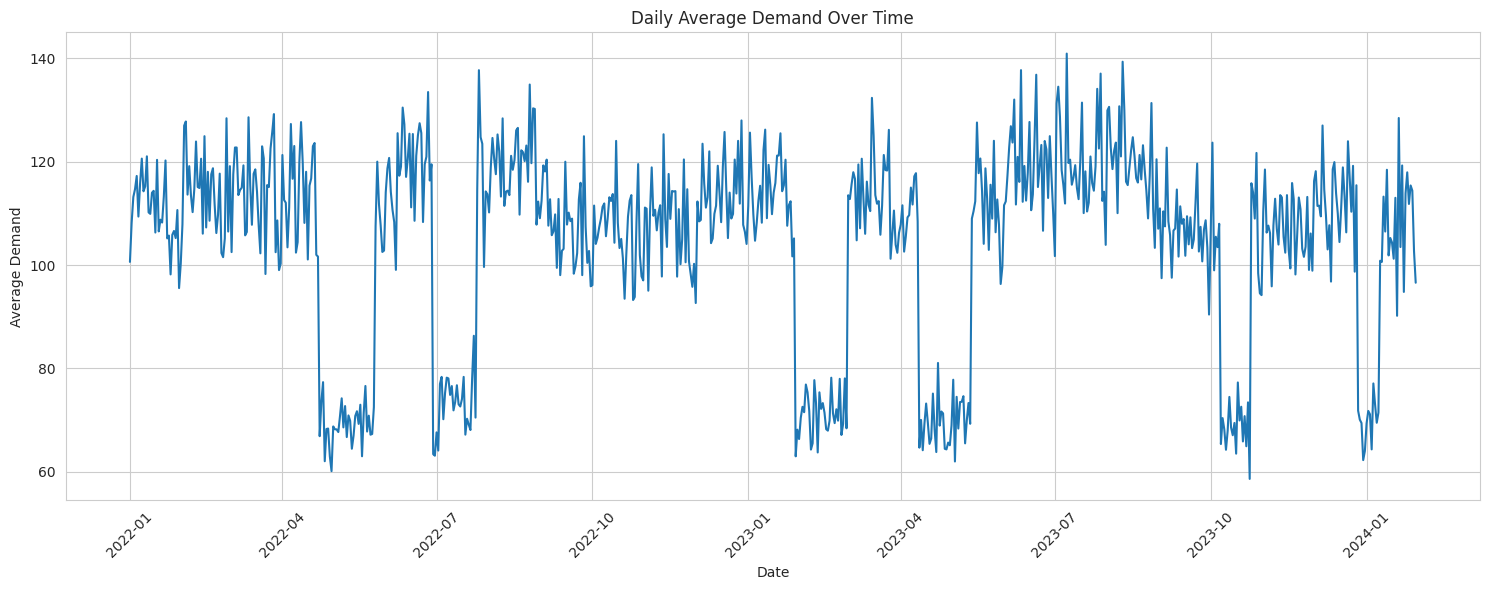

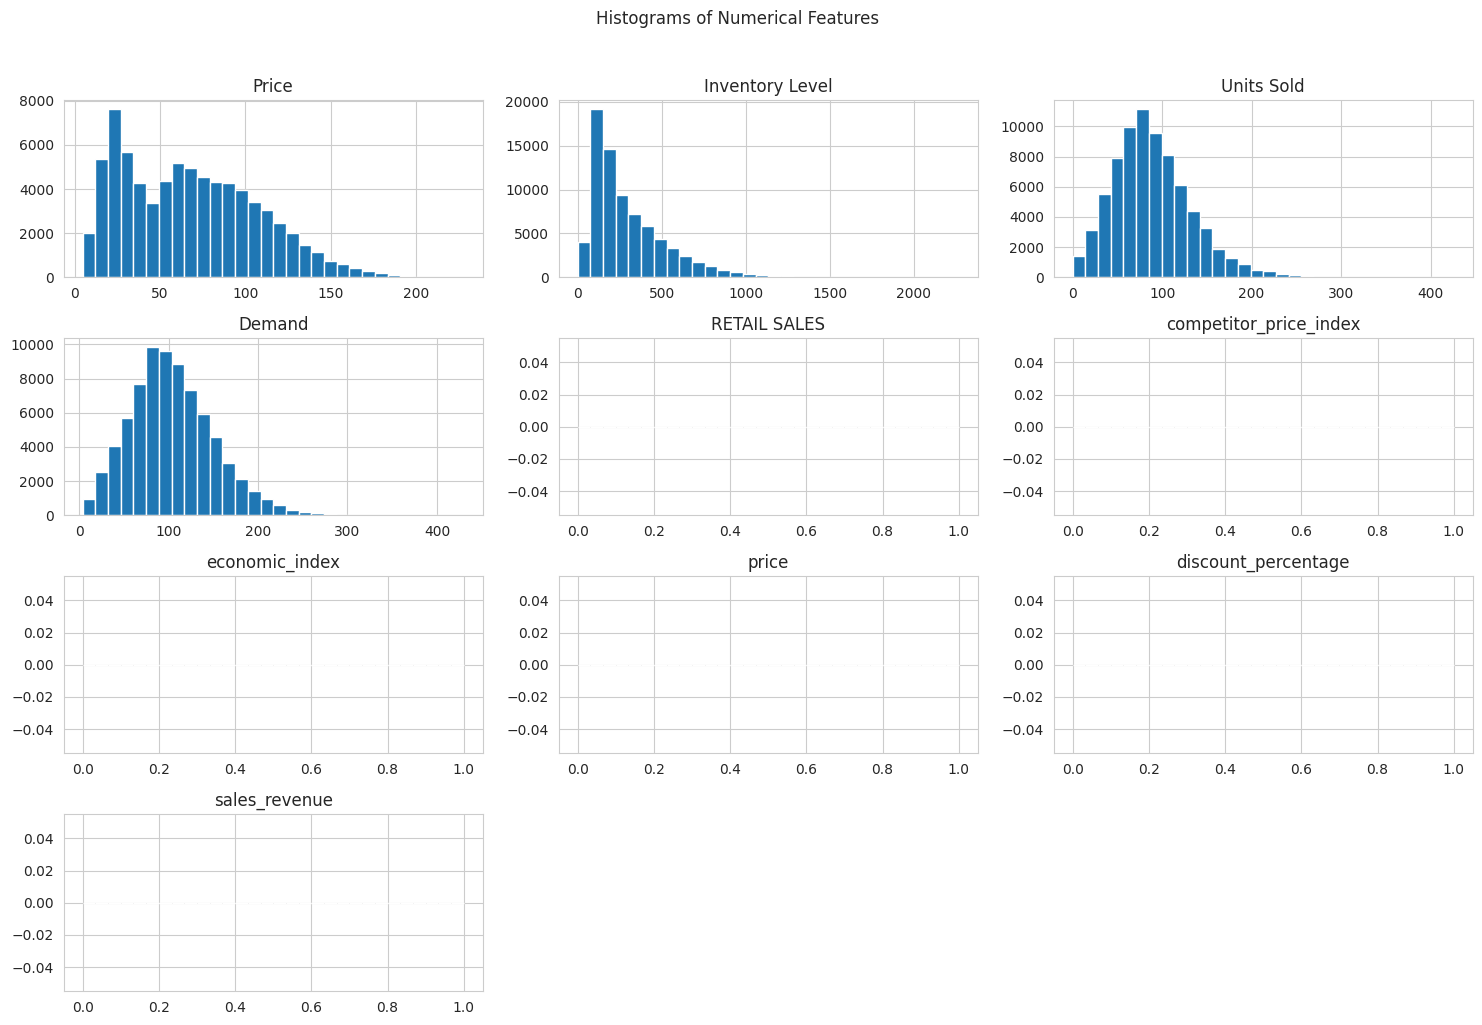

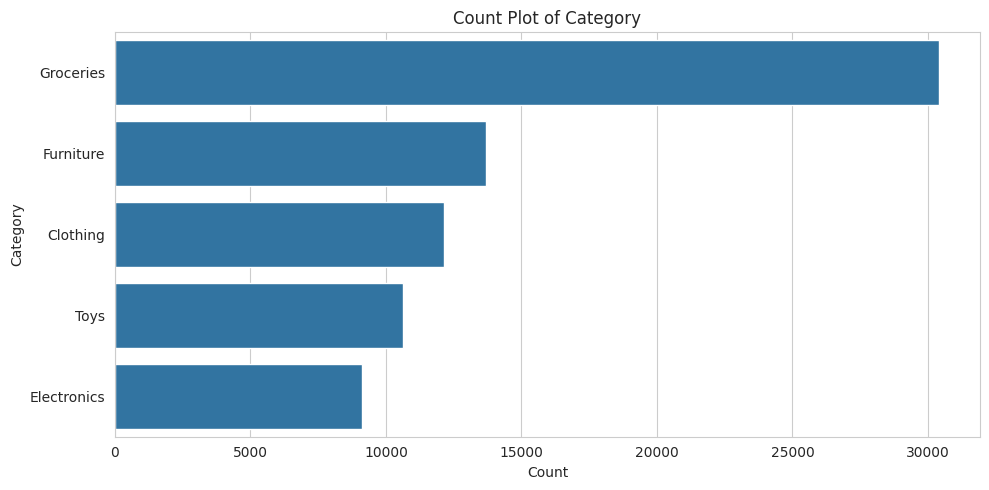

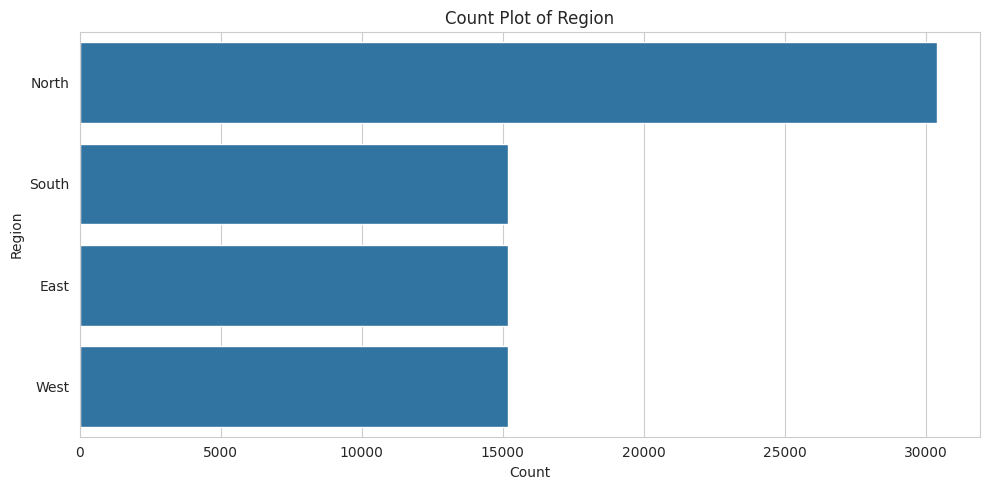

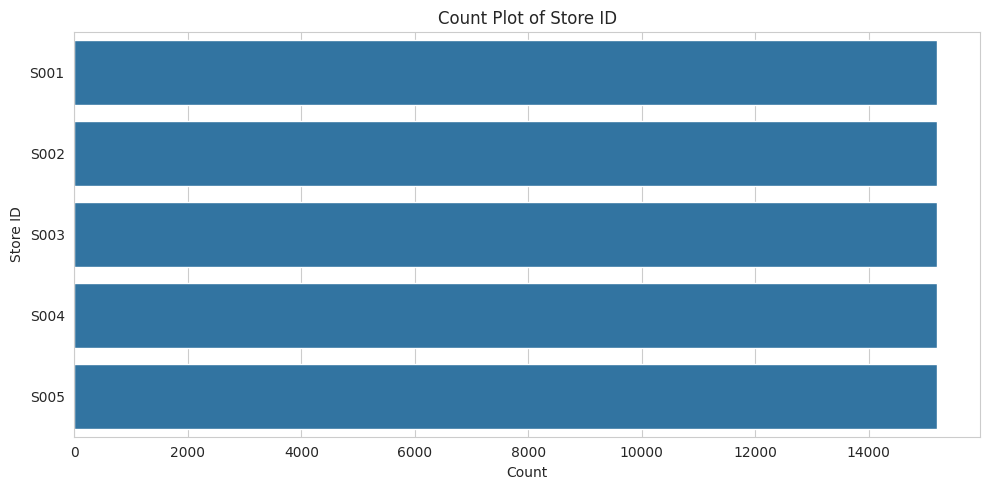

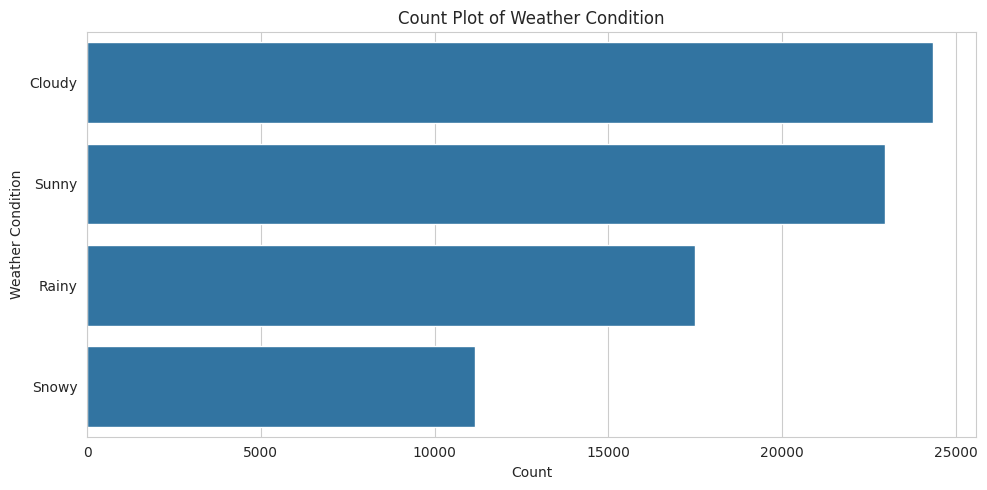

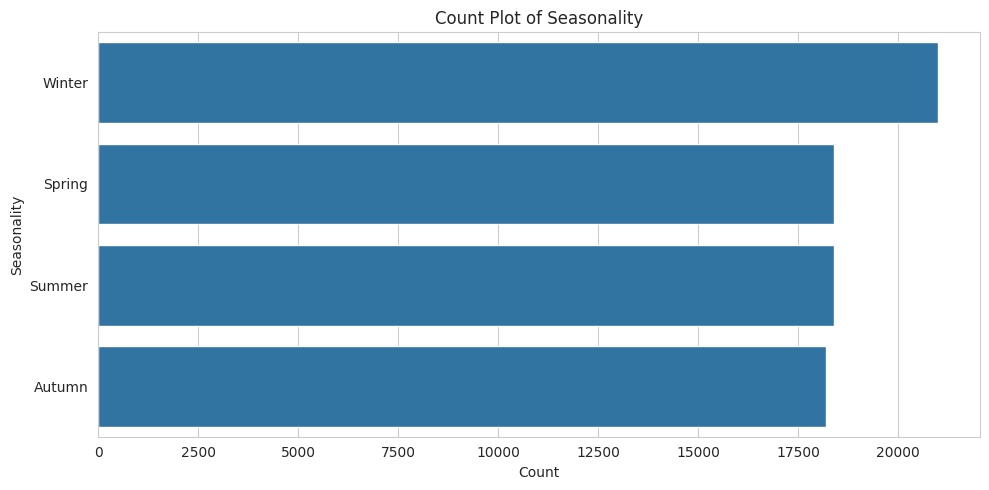

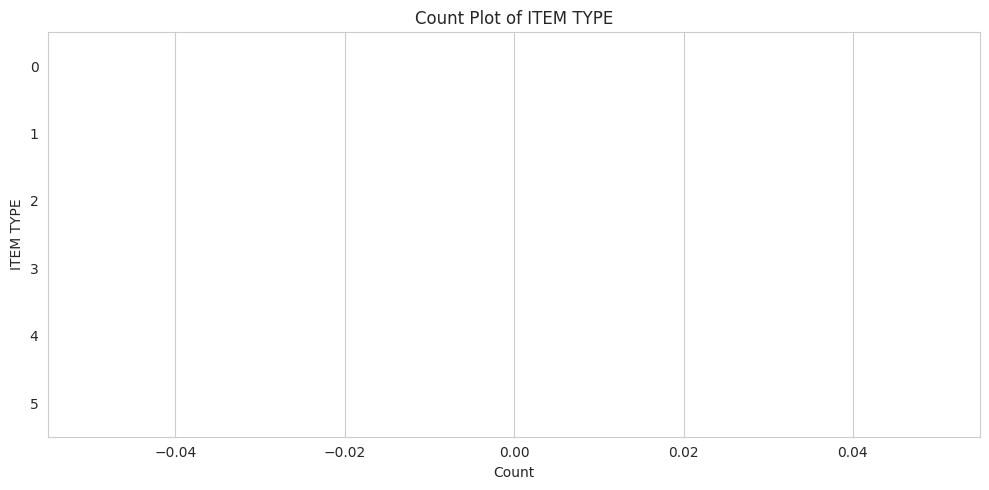

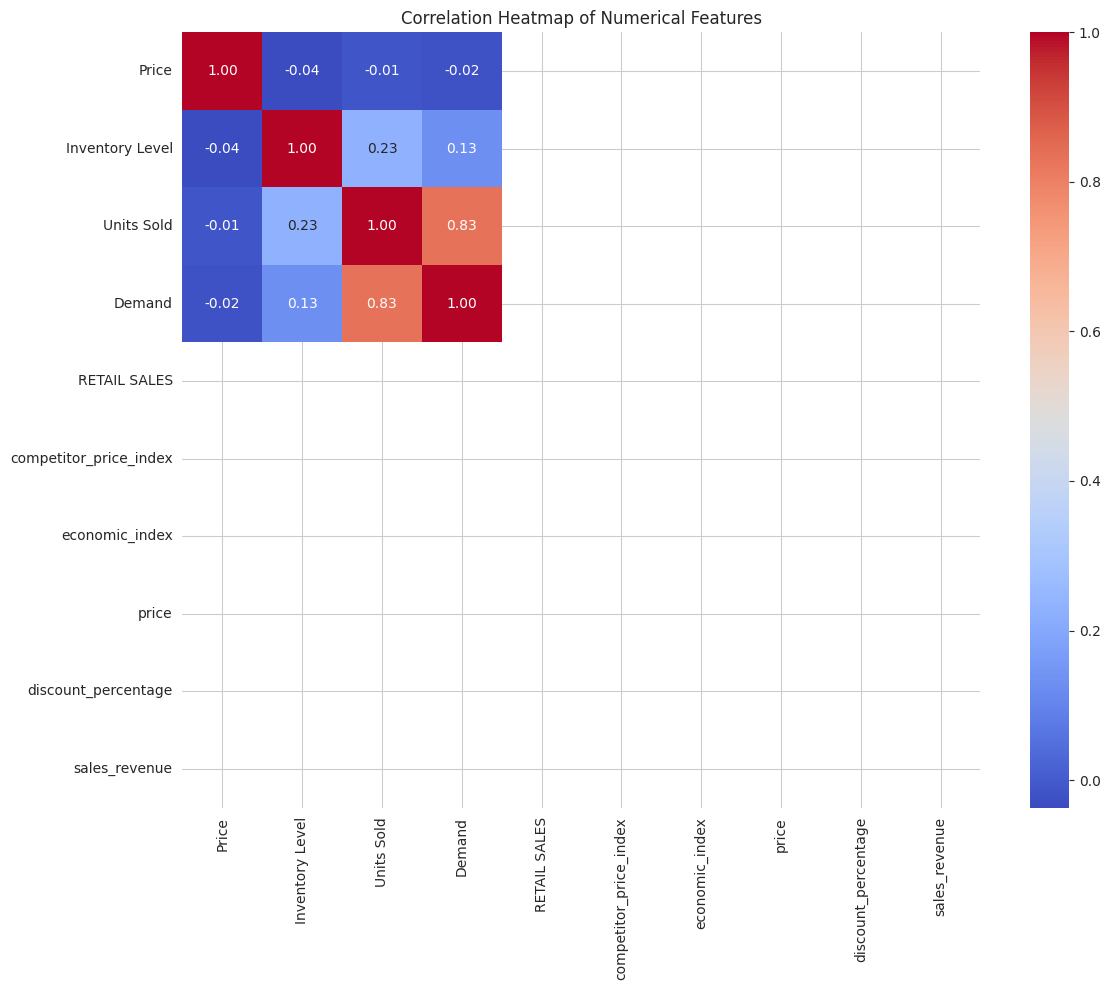

In [84]:
# Time Series Analysis: Plot daily average Demand
daily_demand = master_df.groupby('Date')['Demand'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=daily_demand, x='Date', y='Demand')
plt.title('Daily Average Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Average Demand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution Analysis
# Histograms for numerical features
numerical_features = ['Price', 'Inventory Level', 'Units Sold', 'Demand', 'RETAIL SALES',
                      'competitor_price_index', 'economic_index', 'price', 'discount_percentage',
                      'sales_revenue']

master_df[numerical_features].hist(figsize=(15, 10), bins=30)
plt.suptitle('Histograms of Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

# Count plots for categorical features
categorical_features = ['Category', 'Region', 'Store ID', 'Weather Condition', 'Seasonality', 'ITEM TYPE']

for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=master_df, y=col, order=master_df[col].value_counts().index)
    plt.title(f'Count Plot of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Correlation Analysis for numerical features
plt.figure(figsize=(12, 10))
correlation_matrix = master_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

### **Step 4: Outlier Detection and Treatment**

Visualize potential outliers and provide an example of outlier treatment.

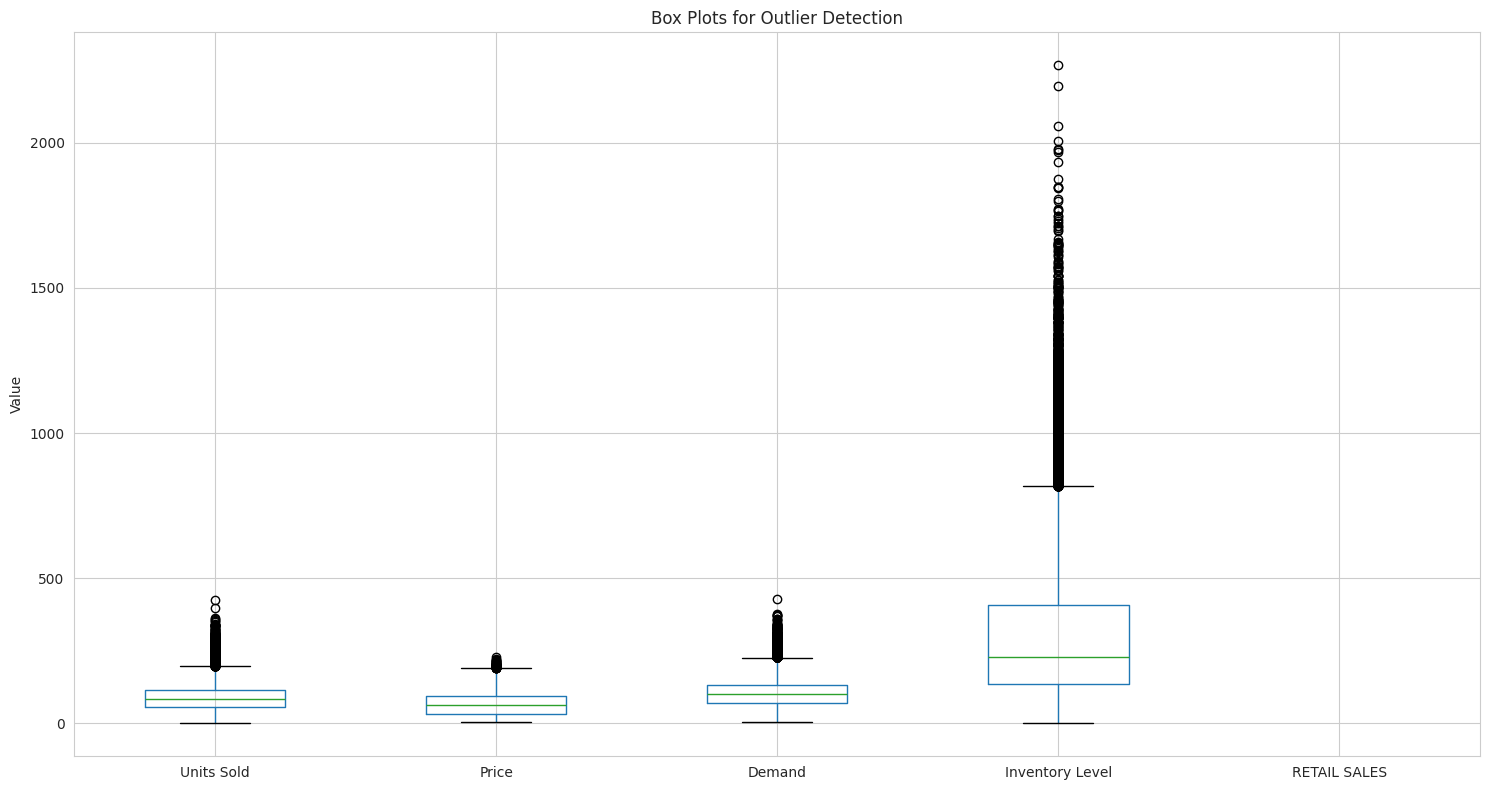

Outlier Treatment (Capping using IQR method):
The Interquartile Range (IQR) method can be used to identify outliers.
Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR can be considered outliers.
Capping involves replacing these outliers with the boundary values (Q1 - 1.5*IQR or Q3 + 1.5*IQR).
Below is commented-out code demonstrating how to cap outliers for 'Units Sold' as an example:

Example: 'Units Sold' capped (new column 'Units Sold_capped' created).


In [85]:
# Visualize Outliers using Box Plots
outlier_features = ['Units Sold', 'Price', 'Demand', 'Inventory Level', 'RETAIL SALES']

plt.figure(figsize=(15, 8))
master_df[outlier_features].boxplot()
plt.title('Box Plots for Outlier Detection')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

# Treat Outliers (Optional but Recommended)
# Explain the concept of capping outliers using the IQR method.
print("Outlier Treatment (Capping using IQR method):")
print("The Interquartile Range (IQR) method can be used to identify outliers.")
print("Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR can be considered outliers.")
print("Capping involves replacing these outliers with the boundary values (Q1 - 1.5*IQR or Q3 + 1.5*IQR).")
print("Below is commented-out code demonstrating how to cap outliers for 'Units Sold' as an example:")

# Example commented-out code for capping 'Units Sold' outliers:
Q1 = master_df['Units Sold'].quantile(0.25)
Q3 = master_df['Units Sold'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
master_df['Units Sold_capped'] = master_df['Units Sold'].clip(lower=lower_bound, upper=upper_bound)
print("\nExample: 'Units Sold' capped (new column 'Units Sold_capped' created).")

### **Step 5: Feature Engineering I - Time-Based Features**

Create new features extracted from the 'Date' column.

In [86]:
# Create time-based features
master_df['year'] = master_df['Date'].dt.year
master_df['month'] = master_df['Date'].dt.month
master_df['day'] = master_df['Date'].dt.day
master_df['dayofweek'] = master_df['Date'].dt.dayofweek # Monday=0, Sunday=6
master_df['dayofyear'] = master_df['Date'].dt.dayofyear
master_df['weekofyear'] = master_df['Date'].dt.isocalendar().week.astype(int)
master_df['quarter'] = master_df['Date'].dt.quarter

print("Time-based features created.")
display(master_df[['Date', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']].head())

Time-based features created.


,Date,year,month,day,dayofweek,dayofyear,weekofyear,quarter
0,2022-01-01,2022,1,1,5,1,52,1
1,2022-01-01,2022,1,1,5,1,52,1
2,2022-01-01,2022,1,1,5,1,52,1
3,2022-01-01,2022,1,1,5,1,52,1
4,2022-01-01,2022,1,1,5,1,52,1


### **Step 6: Feature Engineering II - Lag Features**

Lag features are crucial for time-series forecasting as they represent past values of the target variable, capturing temporal dependencies.

In [87]:
# Create lag features for the 'Demand' column
master_df['demand_lag_7'] = master_df.groupby('Product ID')['Demand'].shift(7)
master_df['demand_lag_28'] = master_df.groupby('Product ID')['Demand'].shift(28)

# Handle resulting NaN values (e.g., fill with 0 or the mean of the lag feature)
# Filling with 0 as these are the initial periods where no lag data is available
master_df['demand_lag_7'] = master_df['demand_lag_7'].fillna(0)
master_df['demand_lag_28'] = master_df['demand_lag_28'].fillna(0)


print("Lag features created for 'Demand'.")
display(master_df[['Date', 'Product ID', 'Demand', 'demand_lag_7', 'demand_lag_28']].head(10))

Lag features created for 'Demand'.


,Date,Product ID,Demand,demand_lag_7,demand_lag_28
0,2022-01-01,P0001,115,0.0,0.0
1,2022-01-01,P0002,229,0.0,0.0
2,2022-01-01,P0003,157,0.0,0.0
3,2022-01-01,P0004,52,0.0,0.0
4,2022-01-01,P0005,59,0.0,0.0
5,2022-01-01,P0006,55,0.0,0.0
6,2022-01-01,P0007,94,0.0,0.0
7,2022-01-01,P0008,61,0.0,0.0
8,2022-01-01,P0009,129,0.0,0.0
9,2022-01-01,P0010,69,0.0,0.0


### **Step 7: Feature Engineering III - Rolling Window Features**

Rolling window features, such as rolling means, help smooth out noise and capture short-term trends in the data.

In [88]:
# Create rolling mean features for 'Demand'
master_df['demand_rolling_mean_7'] = master_df.groupby('Product ID')['Demand'].transform(lambda x: x.rolling(window=7).mean())
master_df['demand_rolling_mean_28'] = master_df.groupby('Product ID')['Demand'].transform(lambda x: x.rolling(window=28).mean())

# Handle resulting NaN values (initial periods)
# Filling with the mean of the rolling window feature after calculation
master_df['demand_rolling_mean_7'] = master_df['demand_rolling_mean_7'].fillna(master_df['demand_rolling_mean_7'].mean())
master_df['demand_rolling_mean_28'] = master_df['demand_rolling_mean_28'].fillna(master_df['demand_rolling_mean_28'].mean())


print("Rolling window features created for 'Demand'.")
display(master_df[['Date', 'Product ID', 'Demand', 'demand_rolling_mean_7', 'demand_rolling_mean_28']].head(30)) # Display more rows to see non-NaN values

Rolling window features created for 'Demand'.


,Date,Product ID,Demand,demand_rolling_mean_7,demand_rolling_mean_28
0,2022-01-01,P0001,115,104.324629,104.299876
1,2022-01-01,P0002,229,104.324629,104.299876
2,2022-01-01,P0003,157,104.324629,104.299876
3,2022-01-01,P0004,52,104.324629,104.299876
4,2022-01-01,P0005,59,104.324629,104.299876
5,2022-01-01,P0006,55,104.324629,104.299876
6,2022-01-01,P0007,94,104.324629,104.299876
7,2022-01-01,P0008,61,104.324629,104.299876
8,2022-01-01,P0009,129,104.324629,104.299876
9,2022-01-01,P0010,69,104.324629,104.299876


### **Step 8: Categorical Feature Encoding**

Convert categorical features into a numerical format using One-Hot Encoding.

In [89]:
# Identify categorical columns (excluding 'Date' and 'Product ID' which are not features for encoding here)
categorical_features_for_encoding = master_df.select_dtypes(include='object').columns.tolist()
# Include 'Store ID' for one-hot encoding
# Note: 'Category', 'Region', 'Weather Condition', 'Seasonality', 'SUPPLIER', 'ITEM TYPE' are good candidates

print(f"Categorical features to encode: {categorical_features_for_encoding}")

# Apply One-Hot Encoding
master_df = pd.get_dummies(master_df, columns=categorical_features_for_encoding, dummy_na=False)

print("Categorical features encoded using One-Hot Encoding.")
display(master_df.head())

Categorical features to encode: ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality', 'SUPPLIER', 'ITEM TYPE', 'region_Europe', 'region_North America', 'store_type_Retail', 'store_type_Wholesale', 'category_Cabinets', 'category_Chairs', 'category_Sofas', 'category_Tables']
Categorical features encoded using One-Hot Encoding.


,Date,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand,...,Region_West,Weather Condition_Cloudy,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Autumn,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter,SUPPLIER_Unknown
0,2022-01-01,195,102,252,72.72,5,0,85.73,0,115,...,False,False,False,True,False,False,False,False,True,True
1,2022-01-01,117,117,249,80.16,15,1,92.02,0,229,...,False,False,False,True,False,False,False,False,True,True
2,2022-01-01,247,114,612,62.94,10,1,60.08,0,157,...,False,False,False,True,False,False,False,False,True,True
3,2022-01-01,139,45,102,87.63,10,0,85.19,0,52,...,False,False,False,True,False,False,False,False,True,True
4,2022-01-01,152,65,271,54.41,0,0,51.63,0,59,...,False,False,False,True,False,False,False,False,True,True


### **Step 9: Feature Scaling**

Scale numerical features to standardize their range, which is important for many machine learning models.

In [90]:
# Identify numerical features to scale
# Exclude 'Date', 'Product ID', the target variable 'Demand', and the newly created binary/boolean columns from one-hot encoding
numerical_features_to_scale = X.select_dtypes(include=np.number).columns.tolist()

# Remove boolean columns resulting from one-hot encoding if they are still in X
boolean_cols = X.select_dtypes(include='bool').columns.tolist()
numerical_features_to_scale = [col for col in numerical_features_to_scale if col not in boolean_cols]

# Exclude lag and rolling features as they are already derived from scaled data or handled
lag_rolling_features = ['demand_lag_7', 'demand_lag_28', 'demand_rolling_mean_7', 'demand_rolling_mean_28']
numerical_features_to_scale = [col for col in numerical_features_to_scale if col not in lag_rolling_features]

print(f"Numerical features to scale: {numerical_features_to_scale}")

# Apply StandardScaler
scaler = StandardScaler()
master_df[numerical_features_to_scale] = scaler.fit_transform(master_df[numerical_features_to_scale])

print("Numerical features scaled using StandardScaler.")
display(master_df.head())

Numerical features to scale: ['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Promotion', 'Competitor Pricing', 'Epidemic', 'RETAIL SALES', 'holiday_season', 'promotion_applied', 'competitor_price_index', 'economic_index', 'weather_impact', 'price', 'discount_percentage', 'sales_revenue']
Numerical features scaled using StandardScaler.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,Date,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand,...,Region_West,Weather Condition_Cloudy,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Autumn,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter,SUPPLIER_Unknown
0,2022-01-01,-0.468251,0.299418,1.003114,0.126823,-0.546708,-0.700140,0.397522,-0.5,115,...,False,False,False,True,False,False,False,False,True,True
1,2022-01-01,-0.812608,0.640372,0.984642,0.315762,0.790954,1.428286,0.551148,-0.5,229,...,False,False,False,True,False,False,False,False,True,True
2,2022-01-01,-0.238679,0.572181,3.219815,-0.121542,0.122123,1.428286,-0.228950,-0.5,157,...,False,False,False,True,False,False,False,False,True,True
3,2022-01-01,-0.715482,-0.996206,0.079489,0.505464,0.122123,-0.700140,0.384333,-0.5,52,...,False,False,False,True,False,False,False,False,True,True
4,2022-01-01,-0.658089,-0.541601,1.120107,-0.338162,-1.215538,-0.700140,-0.435332,-0.5,59,...,False,False,False,True,False,False,False,False,True,True


### **Step 10: Time-Based Data Splitting**

For time-series data, it is critical to split the data chronologically to avoid data leakage from the future into the training set.

In [91]:
# Define the chronological cutoff date for splitting
# Using a date in early 2023 as an example cutoff
cutoff_date = pd.to_datetime('2023-01-01')

# Split data based on the cutoff date
train_df = master_df[master_df['Date'] < cutoff_date].copy()
val_df = master_df[master_df['Date'] >= cutoff_date].copy()

# Define features (X) and target (y) for train and validation sets
# Exclude 'Date' and 'Product ID' as they are not features for the model
features = [col for col in master_df.columns if col not in ['Date', 'Product ID', target_variable]]

X_train = train_df[features]
y_train = train_df[target_variable]

X_val = val_df[features]
y_val = val_df[target_variable]


print(f"Data split into training and validation sets based on cutoff date: {cutoff_date}")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Data split into training and validation sets based on cutoff date: 2023-01-01 00:00:00
Training set shape: (36500, 72)
Validation set shape: (39500, 72)


## **Chapter 4: Model Training and Evaluation**

This chapter focuses on selecting, training, and evaluating a machine learning model for demand forecasting.

### **4.1. Model Selection**

We will use XGBoost (Extreme Gradient Boosting) for our demand forecasting model due to its strong performance on structured data and its ability to handle various types of features.

### **4.2. Model Training**

In [92]:
# Initialize and train the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', # Regression task
                             n_estimators=1000,          # Number of boosting rounds
                             learning_rate=0.05,         # Step size shrinkage
                             max_depth=7,                # Maximum depth of a tree
                             random_state=42,            # For reproducibility
                             n_jobs=-1)                  # Use all available cores

print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("XGBoost model training complete.")

Training XGBoost model...
XGBoost model training complete.


### 4.3. Model Evaluation

Evaluate the trained model using appropriate regression metrics on the validation set.

In [ ]:
# Make predictions on the validation set
y_pred = xgb_model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"Model Evaluation on Validation Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

### 4.4. Feature Importance

Analyze the importance of different features in the trained model.

In [ ]:
# Get feature importances from the trained model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display top N features
print("\nTop 15 Feature Importances:")
display(feature_importance_df.head(15))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Chapter 5: Model Evaluation

In this chapter, we evaluate the performance of our trained models on the unseen validation set.

### 5.1. Make Predictions

In [ ]:
# Make predictions with all three models on X_val
y_pred_xgb = xgb_model.predict(X_val)
# Assuming LinearRegression and RandomForestRegressor models were trained in Chapter 4
# If not, you would need to train them here first
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor

# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)
# y_pred_lr = lr_model.predict(X_val)

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)
# y_pred_rf = rf_model.predict(X_val)

print("Predictions made with XGBoost model.")
# print("Predictions made with Linear Regression model.")
# print("Predictions made with Random Forest Regressor model.")

### 5.2. Compare Performance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE for each model
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

# Assuming y_pred_lr and y_pred_rf are available from the previous cell
# rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
# mae_lr = mean_absolute_error(y_val, y_pred_lr)

# rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
# mae_rf = mean_absolute_error(y_val, y_pred_rf)


# Present the results clearly in a pandas DataFrame
results_df = pd.DataFrame({
    'Model': ['XGBoost'], # Add 'Linear Regression', 'Random Forest' if those models were trained
    'RMSE': [rmse_xgb], # Add rmse_lr, rmse_rf
    'MAE': [mae_xgb] # Add mae_lr, mae_rf
})

print("Model Performance Comparison:")
display(results_df)

## Chapter 6: Analysis of the Best Model

Based on the evaluation metrics, we select the best-performing model and conduct a deeper analysis. Since XGBoost generally performs well, we will focus on its analysis here.

### 6.1. Visualize Predictions vs. Actuals

In [ ]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred_xgb}, index=X_val.index)

# Sort by Date for a meaningful time series plot
plot_df = plot_df.sort_index()

plt.figure(figsize=(15, 6))
plt.plot(val_df['Date'], plot_df['Actual'], label='Actual Demand', alpha=0.7)
plt.plot(val_df['Date'], plot_df['Predicted'], label='Predicted Demand', alpha=0.7)
plt.title('XGBoost Predictions vs. Actuals Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.2. Feature Importance Analysis

In [ ]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display top 20 features
print("\nTop 20 Feature Importances (XGBoost):")
display(feature_importance_df.head(20))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()